Saving smr files to one folder

In [1]:
import os
import shutil
import pandas as pd

# 1. Manually set your base paths
src_dir = "nerve_data"         # contains subfolders "Culex" and "aedes aegypti"
dst_dir = "nerve_data_smr"     # will be populated with the same subfolder structure

# 2. List the subfolders you want to process
subfolders = ["Culex", "aedes aegypti"]

# 3. Ensure destination base exists
os.makedirs(dst_dir, exist_ok=True)

records = []
for sub in subfolders:
    src_sub = os.path.join(src_dir, sub)
    dst_sub = os.path.join(dst_dir, sub)
    
    # skip if source subfolder missing
    if not os.path.isdir(src_sub):
        print(f"Warning: source folder not found: {src_sub}")
        continue
    
    # make matching subfolder in destination
    os.makedirs(dst_sub, exist_ok=True)
    
    # copy all .smr files in this subfolder
    for fname in os.listdir(src_sub):
        if fname.lower().endswith('.smr'):
            src_path = os.path.join(src_sub, fname)
            dst_path = os.path.join(dst_sub, fname)
            shutil.copy2(src_path, dst_path)
            records.append({
                "Subfolder": sub,
                "Filename": fname,
                "Source Path": src_path,
                "Destination Path": dst_path
            })

# (Optional) turn records into a DataFrame for review or export
df = pd.DataFrame(records)
print(df)  # or df.to_csv("copy_log.csv", index=False)


         Subfolder                                           Filename  \
0            Culex  2025_04_03_NI_Cxpp_male_mosq1_-30V_No injectio...   
1            Culex  2025_04_03_NI_Cxpp_male_mosq1_-30V_No injectio...   
2            Culex  2025_04_03_NI_Cxpp_male_mosq1_-30V_No injectio...   
3            Culex  2025_04_03_NI_Cxpp_male_mosq1_-30V_No injectio...   
4            Culex  2025_04_03_NI_Cxpp_male_mosq1_-30V_No injectio...   
..             ...                                                ...   
277  aedes aegypti  160724_Liverpool_male_mos2_222deg_sweeps_-10dB...   
278  aedes aegypti  160724_Liverpool_male_mos2_222deg_sweeps_-10dB...   
279  aedes aegypti  160724_Liverpool_male_mos2_222deg_sweeps_-10dB...   
280  aedes aegypti  160724_Liverpool_male_mos2_222deg_sweeps_-10dB...   
281  aedes aegypti  160724_Liverpool_male_mos2_222deg_sweeps_-10dB...   

                                           Source Path  \
0    nerve_data\Culex\2025_04_03_NI_Cxpp_male_mosq1...   
1    ne

Drawing the sonograms and corresponding data

[+] Saved image: Sonogram_data_all\aedes aegypti\png\030724_Liverpool_male_mos1_253deg_LSwAv_1_sonogram.png
[+] Saved CSV:   Sonogram_data_all\aedes aegypti\csv\030724_Liverpool_male_mos1_253deg_LSwAv_1_sonogram.csv
[+] Saved CSV:   Sonogram_data_all\aedes aegypti\csv\030724_Liverpool_male_mos1_253deg_LSwAv_1_sonogram.csv
[+] Saved image: Sonogram_data_all\aedes aegypti\png\030724_Liverpool_male_mos1_253deg_LSwAv_11_sonogram.png
[+] Saved image: Sonogram_data_all\aedes aegypti\png\030724_Liverpool_male_mos1_253deg_LSwAv_11_sonogram.png
[+] Saved CSV:   Sonogram_data_all\aedes aegypti\csv\030724_Liverpool_male_mos1_253deg_LSwAv_11_sonogram.csv
[+] Saved CSV:   Sonogram_data_all\aedes aegypti\csv\030724_Liverpool_male_mos1_253deg_LSwAv_11_sonogram.csv
[+] Saved image: Sonogram_data_all\aedes aegypti\png\030724_Liverpool_male_mos1_253deg_LSwAv_16_sonogram.png
[+] Saved image: Sonogram_data_all\aedes aegypti\png\030724_Liverpool_male_mos1_253deg_LSwAv_16_sonogram.png
[+] Saved CSV:   Sonog

KeyboardInterrupt: 

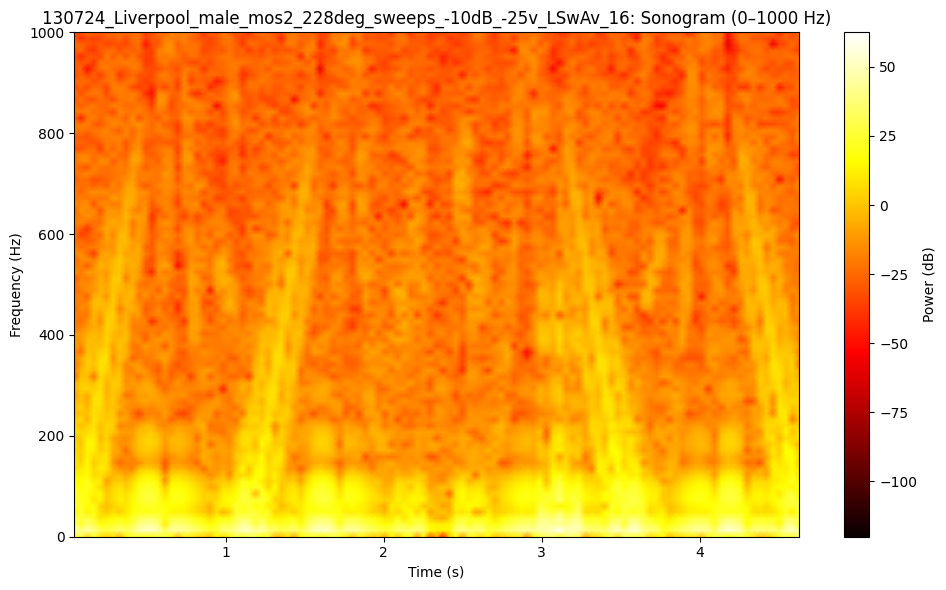

In [7]:
#!/usr/bin/env python3
"""
batch_make_sonograms.py

Walks through all subfolders of INPUT_DIR, finds every .smr file,
applies a Butterworth band-pass filter between 0 and 2000 Hz,
computes a sonogram, and saves both image and CSV
into per-species folders with csv/ and png/ subfolders.
"""

import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
from neo.io import CedIO

# ─── User Parameters ────────────────────────────────────────
INPUT_DIR   = 'nerve_data'         # root folder with .smr in species subfolders
OUTPUT_ROOT = 'Sonogram_data_all'  # top‐level output folder

CHANNEL_IDX = 0
SEGMENT_IDX = 0

MIN_FREQ    = 0
MAX_FREQ    = 1000
ORDER       = 4
NPERSEG     = 8192
NOVERLAP    = NPERSEG // 2
EPSILON     = 1e-12

def process_file(full_path):
    base     = os.path.splitext(os.path.basename(full_path))[0]
    rel_dir  = os.path.relpath(os.path.dirname(full_path), INPUT_DIR)
    species  = rel_dir.split(os.sep)[0]  # top‐level folder under INPUT_DIR

    # build species folder, then its csv/ and png/ subfolders
    species_dir = os.path.join(OUTPUT_ROOT, species)
    csv_dir     = os.path.join(species_dir, 'csv')
    png_dir     = os.path.join(species_dir, 'png')
    os.makedirs(csv_dir, exist_ok=True)
    os.makedirs(png_dir, exist_ok=True)

    img_path = os.path.join(png_dir, f'{base}_sonogram.png')
    csv_path = os.path.join(csv_dir, f'{base}_sonogram.csv')

    # 1. Load data
    reader = CedIO(filename=full_path)
    block  = reader.read_block(lazy=False)
    seg    = block.segments[SEGMENT_IDX]
    analog = seg.analogsignals[CHANNEL_IDX]
    data   = np.array(analog).flatten()
    fs     = 100000  # updated: previously fs = analog.sampling_rate.rescale('Hz').magnitude

    # 2. Design & apply filter
    nyq = fs / 2.0
    if MIN_FREQ <= 0:
        b, a = signal.butter(ORDER, MAX_FREQ/nyq, btype='low')
    else:
        b, a = signal.butter(ORDER, [MIN_FREQ/nyq, MAX_FREQ/nyq], btype='band')
    data = signal.filtfilt(b, a, data)

    # 3. Compute spectrogram
    freqs, times, Sxx = signal.spectrogram(
        data, fs,
        nperseg=NPERSEG,
        noverlap=NOVERLAP,
        scaling='density',
        mode='psd'
    )

    # 4. Convert to dB
    Sxx_dB = 10 * np.log10(Sxx + EPSILON)

    # 5. Plot & save image
    plt.figure(figsize=(10, 6))
    pcm = plt.pcolormesh(times, freqs, Sxx_dB, shading='gouraud', cmap='hot')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.ylim(MIN_FREQ, MAX_FREQ)
    plt.title(f'{base}: Sonogram ({MIN_FREQ}–{MAX_FREQ} Hz)')
    plt.colorbar(pcm, label='Power (dB)')
    plt.tight_layout()
    plt.savefig(img_path, dpi=300)
    plt.close()
    print(f"[+] Saved image: {img_path}")

    # 6. Save raw-power CSV
    df = pd.DataFrame(Sxx, index=freqs, columns=times)
    df.index.name   = 'Frequency_Hz'
    df.columns.name = 'Time_s'
    df.to_csv(csv_path)
    print(f"[+] Saved CSV:   {csv_path}")

def main():
    # create the root output folder
    os.makedirs(OUTPUT_ROOT, exist_ok=True)

    if not os.path.isdir(INPUT_DIR):
        raise FileNotFoundError(f"Directory not found: {INPUT_DIR}")

    # walk all subfolders for .smr files
    for root, _, files in os.walk(INPUT_DIR):
        for fname in files:
            if fname.lower().endswith('.smr'):
                process_file(os.path.join(root, fname))

if __name__ == '__main__':
    main()


In [1]:
#!/usr/bin/env python3
"""
batch_make_sonograms.py

For each .smr file in species subfolders of `nerve_data_smr/`, extract two data ranges
("forward" and "backward"), filter between 0–2000 Hz, compute the spectrogram only
in that band, and save PNG + CSV into organized species-specific subfolders under:

sonogram_data_forward/
    Culex/
        png/
        csv/
    aedes aegypti/
        png/
        csv/
sonogram_data_backward/
    Culex/
        png/
        csv/
    aedes aegypti/
        png/
        csv/

Images are saved with no axes, titles, or colorbars, and only show 0–2000 Hz.
"""

import os
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pandas as pd
from neo.io import CedIO

# ─── User Parameters ────────────────────────────────────────
INPUT_DIR           = 'nerve_data_smr'
OUTPUT_DIR_FORWARD  = 'sonogram_data_forward'
OUTPUT_DIR_BACKWARD = 'sonogram_data_backward'

CHANNEL_IDX = 0
SEGMENT_IDX = 0

MIN_FREQ  = 0
MAX_FREQ  = 1000  # crop spectrogram to this max
ORDER     = 4
NPERSEG   = 8192
NOVERLAP  = NPERSEG // 2
EPSILON   = 1e-12

# ─── Sample ranges ─────────────────────────────────────────
RANGES = {
    'forward':  (10000, 110000),
    'backward': (260000, 360000)
}

def process_segment(base_name, segment_data, fs, label, species):
    # 1) Filter the data
    nyq = fs / 2.0
    if MIN_FREQ <= 0:
        b, a = signal.butter(ORDER, MAX_FREQ/nyq, btype='low')
    else:
        b, a = signal.butter(ORDER, [MIN_FREQ/nyq, MAX_FREQ/nyq], btype='band')
    filtered = signal.filtfilt(b, a, segment_data)

    # 2) Compute full spectrogram
    freqs, times, Sxx = signal.spectrogram(
        filtered, fs,
        nperseg=NPERSEG,
        noverlap=NOVERLAP,
        scaling='density',
        mode='psd'
    )
    Sxx_dB = 10 * np.log10(Sxx + EPSILON)

    # 3) Crop to 0–2000 Hz
    mask = freqs <= MAX_FREQ
    freqs_crop = freqs[mask]
    Sxx_crop  = Sxx_dB[mask, :]

    # 4) Prepare output dirs
    root = OUTPUT_DIR_FORWARD if label == 'forward' else OUTPUT_DIR_BACKWARD
    species_dir = os.path.join(root, species)
    png_dir     = os.path.join(species_dir, 'png')
    csv_dir     = os.path.join(species_dir, 'csv')
    os.makedirs(png_dir, exist_ok=True)
    os.makedirs(csv_dir, exist_ok=True)

    # 5) Save PNG (no axes, title, or colorbar)
    img_path = os.path.join(png_dir, f'{base_name}_{label}.png')
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(times, freqs_crop, Sxx_crop, shading='gouraud',cmap='hot')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(img_path, dpi=300, bbox_inches='tight', pad_inches=0)
    plt.close()
    print(f"[+] Saved image: {img_path}")

    # 6) Save CSV of the cropped power (linear scale)
    csv_path = os.path.join(csv_dir, f'{base_name}_{label}.csv')
    df = pd.DataFrame(
        data=Sxx[mask, :],           # use linear-power Sxx if you prefer
        index=freqs_crop,
        columns=times
    )
    df.index.name   = 'Frequency_Hz'
    df.columns.name = 'Time_s'
    df.to_csv(csv_path)
    print(f"[+] Saved CSV:   {csv_path}")


def process_file(filepath, species):
    base_name = os.path.splitext(os.path.basename(filepath))[0]
    reader = CedIO(filename=filepath)
    block  = reader.read_block(lazy=False)

    # Check segment & channel
    if SEGMENT_IDX >= len(block.segments):
        print(f"[-] {base_name}: missing segment {SEGMENT_IDX}")
        return
    seg = block.segments[SEGMENT_IDX]
    if CHANNEL_IDX >= len(seg.analogsignals):
        print(f"[-] {base_name}: missing channel {CHANNEL_IDX}")
        return

    analog = seg.analogsignals[CHANNEL_IDX]
    data = np.array(analog).flatten()
    fs   = analog.sampling_rate.rescale('Hz').magnitude

    for label, (start, end) in RANGES.items():
        if end > len(data):
            print(f"[-] {base_name} [{label}]: data too short ({len(data)})")
            continue
        segment_data = data[start:end]
        process_segment(base_name, segment_data, fs, label, species)


def main():
    if not os.path.isdir(INPUT_DIR):
        raise FileNotFoundError(f"Directory not found: {INPUT_DIR}")

    # Iterate species subfolders
    for species in os.listdir(INPUT_DIR):
        spath = os.path.join(INPUT_DIR, species)
        if not os.path.isdir(spath):
            continue
        for fname in os.listdir(spath):
            if fname.lower().endswith('.smr'):
                process_file(os.path.join(spath, fname), species)


if __name__ == '__main__':
    main()


[+] Saved image: sonogram_data_forward\aedes aegypti\png\030724_Liverpool_male_mos1_253deg_LSwAv_1_forward.png
[+] Saved CSV:   sonogram_data_forward\aedes aegypti\csv\030724_Liverpool_male_mos1_253deg_LSwAv_1_forward.csv
[+] Saved image: sonogram_data_backward\aedes aegypti\png\030724_Liverpool_male_mos1_253deg_LSwAv_1_backward.png
[+] Saved CSV:   sonogram_data_backward\aedes aegypti\csv\030724_Liverpool_male_mos1_253deg_LSwAv_1_backward.csv
[+] Saved image: sonogram_data_forward\aedes aegypti\png\030724_Liverpool_male_mos1_253deg_LSwAv_11_forward.png
[+] Saved CSV:   sonogram_data_forward\aedes aegypti\csv\030724_Liverpool_male_mos1_253deg_LSwAv_11_forward.csv
[+] Saved image: sonogram_data_backward\aedes aegypti\png\030724_Liverpool_male_mos1_253deg_LSwAv_11_backward.png
[+] Saved CSV:   sonogram_data_backward\aedes aegypti\csv\030724_Liverpool_male_mos1_253deg_LSwAv_11_backward.csv
[+] Saved image: sonogram_data_forward\aedes aegypti\png\030724_Liverpool_male_mos1_253deg_LSwAv_16_